In [1]:
!pip freeze

absl-py==2.1.0
anyio==4.6.2.post1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
astunparse==1.6.3
async-lru==2.0.4
attrs==24.2.0
babel==2.16.0
beautifulsoup4==4.12.3
bleach==6.2.0
certifi==2024.8.30
cffi==1.17.1
charset-normalizer==3.4.0
colorama==0.4.6
comm==0.2.2
contourpy==1.3.1
cycler==0.12.1
debugpy==1.8.9
decorator==5.1.1
defusedxml==0.7.1
executing==2.1.0
fastjsonschema==2.20.0
flatbuffers==24.3.25
fonttools==4.55.0
fqdn==1.5.1
gast==0.6.0
google-pasta==0.2.0
grpcio==1.68.0
h11==0.14.0
h5py==3.12.1
httpcore==1.0.7
httpx==0.27.2
idna==3.10
ipykernel==6.29.5
ipython==8.29.0
isoduration==20.11.0
jedi==0.19.2
Jinja2==3.1.4
joblib==1.4.2
json5==0.9.28
jsonpointer==3.0.0
jsonschema==4.23.0
jsonschema-specifications==2024.10.1
jupyter-events==0.10.0
jupyter-lsp==2.2.5
jupyter_client==8.6.3
jupyter_core==5.7.2
jupyter_server==2.14.2
jupyter_server_terminals==0.5.3
jupyterlab==4.2.6
jupyterlab_pygments==0.3.0
jupyterlab_server==2.27.3
keras==3.6.0
kiwisol

In [2]:
!python -V

Python 3.12.0


In [3]:
%%time
# imports
import os
import time
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import joblib
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import layers, models

CPU times: total: 656 ms
Wall time: 3.28 s


In [4]:
%%time
# read in data and preprocess
images_path = './data/archive3/ASL_Alphabet_Dataset/asl_alphabet_train/'
images = []

for directory in os.listdir(images_path):
    for file in os.listdir(images_path+directory):
        file_path = images_path+directory+'/'+file
        image = Image.open(file_path)
        image = image.convert('L') # convert to grayscale
        image = image.resize((128, 128)) # resize
        # image.save('./data/resized/'+file) # uncomment to save the resized image
        image = np.array(image) # convert to array
        image = image / 255.0 # normalize
        image = image.astype(np.float32)
        images.append((directory, image))

x = [image[1] for image in images]
y = [image[0] for image in images]

CPU times: total: 1min 59s
Wall time: 18min 57s


In [5]:
%%time
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

x_train = np.array(x_train)
x_test = np.array(x_test)


# binarize the labels
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.transform(y_test)

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_test.shape, x_test.dtype)
print(y_test.shape, y_test.dtype)

(178459, 128, 128) float32
(178459, 29) int32
(44615, 128, 128) float32
(44615, 29) int32
CPU times: total: 11.8 s
Wall time: 3min 21s


In [6]:
# x_train_memmap = np.memmap('x_train_memmap2.dat', dtype=x_train.dtype, mode='w+', shape=x_train.shape)
# y_train_memmap = np.memmap('y_train_memmap2.dat', dtype=y_train.dtype, mode='w+', shape=y_train.shape)
# x_test_memmap = np.memmap('x_test_memmap2.dat', dtype=x_test.dtype, mode='w+', shape=x_test.shape)
# y_test_memmap = np.memmap('y_test_memmap2.dat', dtype=y_test.dtype, mode='w+', shape=y_test.shape)

# x_train_memmap[:] = x_train
# y_train_memmap[:] = y_train
# x_test_memmap[:] = x_test
# y_test_memmap[:] = y_test

# x_train_memmap.flush()
# y_train_memmap.flush()
# x_test_memmap.flush()
# y_test_memmap.flush()

In [7]:
# x_train = np.memmap('x_train_memmap2.dat', dtype=np.float32, mode='r', shape=(178459, 128, 128))
# y_train = np.memmap('y_train_memmap2.dat', dtype=np.int32, mode='r', shape=(178459, 29))
# x_test = np.memmap('x_test_memmap2.dat', dtype=np.float32, mode='r', shape=(44615, 128, 128))
# y_test = np.memmap('y_test_memmap2.dat', dtype=np.int32, mode='r', shape=(44615, 29))

In [8]:
y_train.shape
# y_train[:5]

(178459, 29)

In [9]:
%%time
model = models.Sequential([
   layers.Conv2D(8, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(29, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=50, batch_size=128, validation_split=0.2)

C:\Users\John Califano\Desktop\AIProj\live_ASL_reader\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 447s 397ms/step - accuracy: 0.2838 - loss: 2.4416 - val_accuracy: 0.8332 - val_loss: 0.6385
Epoch 2/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 407s 364ms/step - accuracy: 0.6828 - loss: 0.9672 - val_accuracy: 0.9193 - val_loss: 0.3387
Epoch 3/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 395s 354ms/step - accuracy: 0.7690 - loss: 0.6899 - val_accuracy: 0.9423 - val_loss: 0.2377
Epoch 4/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 367s 329ms/step - accuracy: 0.8087 - loss: 0.5633 - val_accuracy: 0.9546 - val_loss: 0.1874
Epoch 5/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 372s 334ms/step - accuracy: 0.8374 - loss: 0.4785 - val_accuracy: 0.9658 - val_loss: 0.1531
Epoch 6/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 371s 333ms/step - accuracy: 0.8596 - loss: 0.4117 - val_accuracy: 0.9690 - val_loss: 0.1250
Epoch 7/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 377s 338ms/step - accuracy: 0.8752 - loss: 0.3643 - val_accuracy: 0.9770 - val_loss: 0.1003
Epoch 8/50
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 367s 329ms/step - ac

# Performance Graph

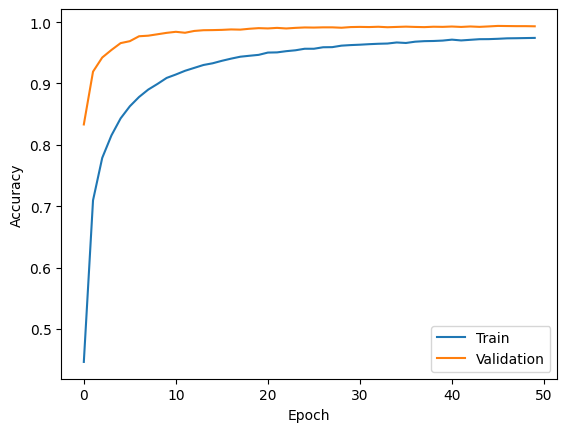

In [10]:
# plot model performance
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Loss and Accuracy measures

# 

In [11]:
# print results of test data ran through model
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(test_loss)
print(test_accuracy)

1395/1395 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - accuracy: 0.9925 - loss: 0.0301
0.029039254412055016
0.9934102892875671


In [12]:
classes = { 0: "A",
            1: "B",
            2: "C",
            3: "D",
            4: "del",
            5: "E",
            6: "F",
            7: "G",
            8: "H",
            9: "I",
            10: "J",
            11: "K",
            12: "L",
            13: "M",
            14: "N",
            15: "nothing",
            16: "O",
            17: "P",
            18: "Q",
            19: "R",
            20: "S",
            21: "space",
            22: "T",
            23: "U",
            24: "V",
            25: "W",
            26: "X",
            27: "Y",
            28: "Z",
            }

# Confusion Matrix

1395/1395 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step


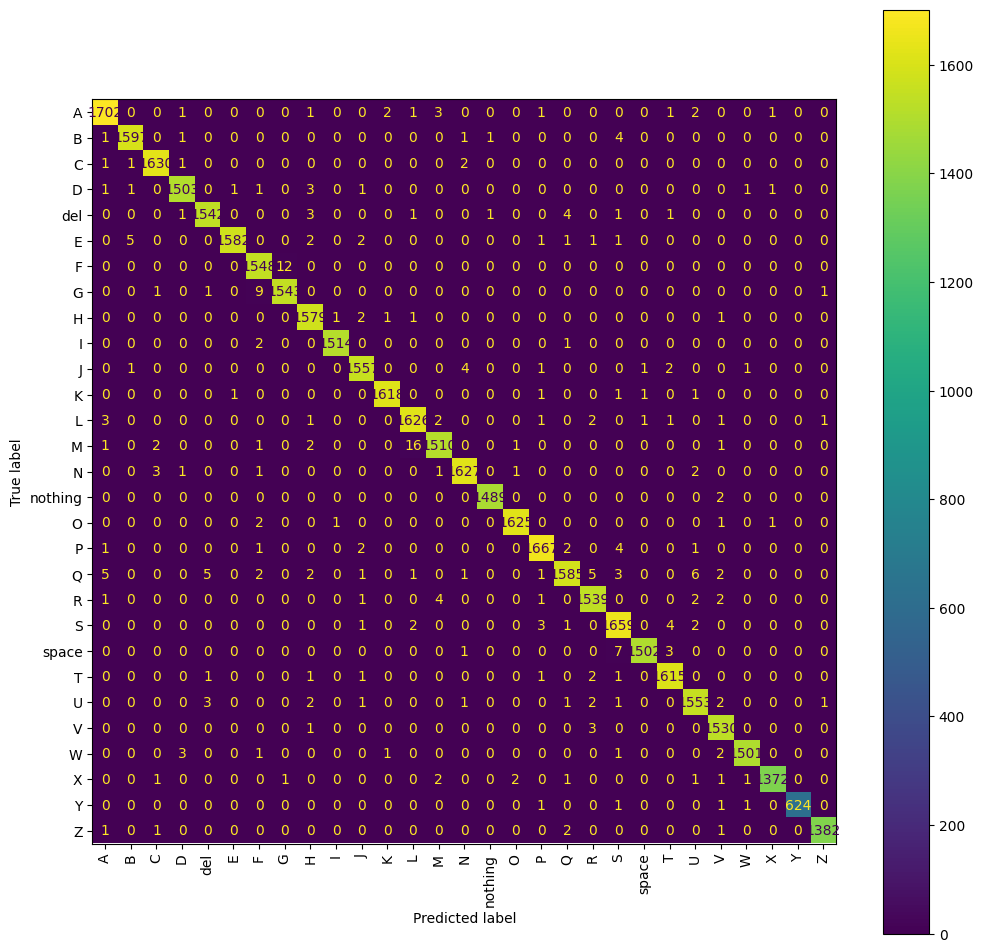

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes.values())
disp.plot( values_format='d', ax=plt.gca())
plt.xticks(rotation=90)
plt.show()

# Classification Report

In [14]:
 print(classification_report(y_true, y_pred_classes, target_names= classes.values())) 

              precision    recall  f1-score   support

           A       0.99      0.99      0.99      1715
           B       1.00      1.00      1.00      1605
           C       1.00      1.00      1.00      1635
           D       0.99      0.99      0.99      1513
         del       0.99      0.99      0.99      1554
           E       1.00      0.99      1.00      1595
           F       0.99      0.99      0.99      1560
           G       0.99      0.99      0.99      1555
           H       0.99      1.00      0.99      1585
           I       1.00      1.00      1.00      1517
           J       0.99      0.99      0.99      1567
           K       1.00      1.00      1.00      1623
           L       0.99      0.99      0.99      1639
           M       0.99      0.98      0.99      1534
           N       0.99      0.99      0.99      1636
     nothing       1.00      1.00      1.00      1491
           O       1.00      1.00      1.00      1630
           P       0.99    

## If model seems good, save it with the following cell

In [15]:
# save model and lebal binarizer with date and time
from datetime import datetime
# label_binarizer = LabelBinarizer()

keras_model_save_name = './keras_saves/' + datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + '.keras'
label_binarizer_save_name = './binarizer/' + datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + '.pkl'
joblib.dump(label_binarizer, label_binarizer_save_name) # save label binarizer
model.save(keras_model_save_name) # save keras model

## The following cells are not needed for the research portion. They will only be used when we decide what model is best after research

In [18]:
model_name_to_export = 'E'

In [19]:
# load trained model
from tensorflow.keras.models import load_model
load_name ='./keras_saves/' +  model_name_to_export + '.keras'
model = load_model(load_name, compile=False) 
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 8)         │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │           4,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 29)                  │           3,741 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,293,741 (12.56 MB)

 Trainable params: 3,293,741 (12.56 MB)

 Non-trainable params: 0 (0.00 B)

None


In [20]:
# export model
model.export('./model_exports/')

INFO:tensorflow:Assets written to: ./model_exports/assets


INFO:tensorflow:Assets written to: ./model_exports/assets


Saved artifact at './model_exports/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 29), dtype=tf.float32, name=None)
Captures:
  2294615169872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2294615170256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2294615170448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2294615171408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2294615171600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2294615172176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2294615171792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2294615173712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2294615174096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2294615175056: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
# load exported model
import tensorflow as tf
reloaded_artifact = tf.saved_model.load('./model_exports/')
print(reloaded_artifact.signatures)


In [ ]:
# prepocess test image
# test_img_path = './data/archive/asl_alphabet_test/asl_alphabet_test/L_test.jpg'
test_img_path = './data/test/test4.jpeg'
og_image = Image.open(test_img_path)
image = og_image.convert('L') # convert to grayscale
image = image.resize((128, 128)) # resize
image = np.array(image) # convert to array
image = image / 255.0 # normalize
image_array = np.expand_dims(image, axis=-1) 
image_array = np.expand_dims(image_array, axis=0) 


In [ ]:
# predict test image
predictions = reloaded_artifact.serve(image_array)
rounded = np.round(predictions)
b_load_name = './binarizer/' + model_name_to_export + '.pkl'
label_binarizer = joblib.load(b_load_name) 
original_label = label_binarizer.inverse_transform(rounded)
print(original_label)